In [247]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [248]:
# Data ingestion and preview.

df=pd.read_csv('data/realestate.csv')
df.head()

,time,province,county,city,area,neighborhood,title,type,price,parking,rooms,sqrm,floor,surface,elevator,tag
0,01/04/2023,Barcelona,Maresme,Arenys de Munt,NaN,NaN,Chalet en Arenys de Munt,venta,360000,1,3.0,182,NaN,NaN,NaN,NaN
1,01/04/2023,Barcelona,Maresme,Arenys de Munt,NaN,NaN,Casa o chalet independiente en Arenys de Munt,venta,570000,0,5.0,266,NaN,NaN,NaN,NaN
2,01/04/2023,Barcelona,Maresme,Arenys de Munt,NaN,NaN,"Chalet en riera i Penya, Arenys de Munt",venta,220000,0,8.0,320,NaN,NaN,NaN,NaN
3,01/04/2023,Barcelona,Maresme,Arenys de Munt,NaN,NaN,Casa o chalet independiente en Urbanització Co...,venta,495000,1,6.0,199,NaN,NaN,NaN,NaN
4,01/04/2023,Barcelona,Maresme,Arenys de Munt,NaN,NaN,Chalet en Arenys de Munt,venta,575000,1,5.0,202,NaN,NaN,NaN,Lujo


In [249]:
# Let's have a first glance at the categories.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8116 entries, 0 to 8115
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          8116 non-null   object 
 1   province      8116 non-null   object 
 2   county        8116 non-null   object 
 3   city          8116 non-null   object 
 4   area          4539 non-null   object 
 5   neighborhood  548 non-null    object 
 6   title         8116 non-null   object 
 7   type          8116 non-null   object 
 8   price         8116 non-null   int64  
 9   parking       8116 non-null   int64  
 10  rooms         8104 non-null   float64
 11  sqrm          8113 non-null   object 
 12  floor         3345 non-null   object 
 13  surface       3221 non-null   object 
 14  elevator      3827 non-null   float64
 15  tag           1396 non-null   object 
dtypes: float64(2), int64(2), object(12)
memory usage: 1014.6+ KB


There are a few columns with object or float types that sould be int. These are:
'rooms' is float
sqrm is object
floor is object
elevator is float

We will amend this later along other issues.

In [250]:
# Let's take a look at missing values.

df.isnull().sum()

time               0
province           0
county             0
city               0
area            3577
neighborhood    7568
title              0
type               0
price              0
parking            0
rooms             12
sqrm               3
floor           4771
surface         4895
elevator        4289
tag             6720
dtype: int64

The missing values in 'floor' and 'elevator' should belong to 'house' property types. Let's check it.

In [251]:
# But first let's see what do the most frequent values look like

df['floor'].value_counts()

floor
1    868
2    807
0    580
3    508
4    248
5    173
6     66
7     43
8     27
9     23
-      2
Name: count, dtype: int64

In [252]:
# We see some values '-' that really should be '-1'. Let's make all the changes mentioned before. First, replacing those '-' values.

df['floor'] = df['floor'].replace('-', '-1')

In [253]:
# We will create a new feature 'property_type' using 'title'. We noticed in the preview that the first word of every string describes the property type.
# Also drop 'title' as it does not have any other use case. 

df['property_type'] = [x.split()[0] for x in df['title']]
df=df.drop(labels=['title'], axis=1)

In [254]:
# Now we can check the percentage of missing values per categorey type. To do that we need to change the column type from object to float

df['floor'] = df['floor'].astype(float)
df.groupby('property_type')['floor'].apply(lambda x: x.isna().sum()/len(x)*100)

property_type
Casa        100.000000
Castillo    100.000000
Chalet      100.000000
Cortijo     100.000000
Dúplex       12.435233
Estudio     100.000000
Finca       100.000000
Masía       100.000000
Piso         14.268293
Torre       100.000000
Ático        15.217391
Name: floor, dtype: float64

In [255]:
# It seems that it is the case. Only 'Piso', 'Dúplex' and 'Átic' don't have 100% of missing values.
# To these categories we will attribute the most frequent for their property type while all the rest should have a 0 value.
# Estudio has 100% of missing values and one would think it's a category similar to 'Piso' or 'Dúplex'. Let's have a look

df[df['property_type']=='Estudio'].head(13)

,time,province,county,city,area,neighborhood,type,price,parking,rooms,sqrm,floor,surface,elevator,tag,property_type
69,01/04/2023,Barcelona,Maresme,Arenys de Munt,NaN,NaN,venta,560000,0,4.0,Bajo sin ascen,NaN,NaN,NaN,Loft,Estudio
899,01/04/2023,Barcelona,Maresme,Calella,NaN,NaN,venta,120000,0,NaN,Planta 3ª exterior con ascen,NaN,NaN,NaN,NaN,Estudio
933,01/04/2023,Barcelona,Maresme,Calella,NaN,NaN,venta,72000,0,NaN,Bajo exterior sin ascen,NaN,NaN,NaN,NaN,Estudio
1775,01/04/2023,Barcelona,Maresme,Malgrat de Mar,NaN,NaN,venta,95000,0,NaN,Planta 7ª exterior con ascen,NaN,NaN,NaN,NaN,Estudio
4549,01/04/2023,Barcelona,Maresme,Mataró,Centre,NaN,venta,293000,1,2.0,Bajo exterior con ascen,NaN,NaN,NaN,Loft,Estudio
5078,01/04/2023,Barcelona,Maresme,Mataró,La Llantia,NaN,venta,150000,0,1.0,Planta 4ª interior sin ascen,NaN,NaN,NaN,Loft,Estudio
5521,01/04/2023,Barcelona,Maresme,Pineda de Mar,Centre,NaN,venta,79900,0,NaN,Bajo exterior sin ascen,NaN,NaN,NaN,NaN,Estudio
6535,01/04/2023,Barcelona,Maresme,Sant Vicenç de Montalt,Platja de Sant Vicenç,NaN,venta,399000,1,NaN,Bajo exterior sin ascen,NaN,NaN,NaN,Loft,Estudio
7124,01/04/2023,Barcelona,Maresme,Tordera,Tordera,NaN,venta,59400,0,NaN,Planta 1ª exterior con ascen,NaN,NaN,NaN,NaN,Estudio
7823,01/04/2023,Barcelona,Maresme,Malgrat de Mar,NaN,NaN,alquiler,499,0,NaN,Planta 2ª interior sin ascen,NaN,NaN,NaN,NaN,Estudio


In [256]:
# All the data for this type of property is missing or wrongly imputed so we will drop it

df = df[df['property_type'] != 'Estudio']

In [257]:
# We also drop 'Finca' as this listings refer to terrains and not actual buildings

df = df[df['property_type'] != 'Finca']

In [258]:
# We fill the missing values with a 0 for all the 'non-flat' categories

df.loc[df['property_type'].isin(['Casa', 'Castillo', 'Chalet', 'Cortijo', 'Finca', 'Masía', 'Torre']), 'floor'] = '0'
df['floor'].isna().groupby(df['property_type']).sum()

property_type
Casa          0
Castillo      0
Chalet        0
Cortijo       0
Dúplex       48
Masía         0
Piso        468
Torre         0
Ático        35
Name: floor, dtype: int64

In [259]:
# Now we can inpute the rest of the missing values with the mean of their 'property_type'.
# This is done because the floor mean of 'Áticos' is probably different than the mean of 'Piso'
# To do this we need to change the column type to float first. Which accepts NaN values and after the computation we can finally change it to integers.

df['floor'] = df['floor'].astype(float)
df['floor'] = df['floor'].fillna(df.groupby('property_type')['floor'].transform('mean'))
df['floor'] = df['floor'].astype(int)

In [260]:
# Elevator has many missing values and presumably is a similar case a 'floor' where missing values belong to house type properties
df.groupby('property_type')['elevator'].apply(lambda x: x.isna().sum()/len(x)*100)

property_type
Casa        100.000000
Castillo    100.000000
Chalet      100.000000
Cortijo     100.000000
Dúplex        0.777202
Masía       100.000000
Piso          1.890244
Torre       100.000000
Ático         1.739130
Name: elevator, dtype: float64

In [261]:
# It looks exactly the same case so we will repeat the same process we did for 'floor'

df.loc[df['property_type'].isin(['Casa', 'Castillo', 'Chalet', 'Cortijo', 'Finca', 'Masía', 'Torre']), 'elevator'] = '0'
df['elevator'] = df['elevator'].astype(float)
df['elevator'] = df['elevator'].fillna(df.groupby('property_type')['elevator'].transform('mean'))
df['elevator'] = df['elevator'].astype(int)

In [262]:
# For 'surface', we will replace NaN with 0 and 'surface' with 1, then we will change the dtype to integer.
# This way, we will obtain a binary column

df['surface'] = df['surface'].fillna('0')
df['surface'] = df['surface'].replace('outdoor', '1')
df['surface'] = df['surface'].astype(int)

In [263]:
# How many NaN do we have left?

df.isna().sum()

time                0
province            0
county              0
city                0
area             3534
neighborhood     7481
type                0
price               0
parking             0
rooms               2
sqrm                3
floor               0
surface             0
elevator            0
tag              6667
property_type       0
dtype: int64

In [264]:
# There are 2 NaN in 'rooms' and 3 in 'sqrm'. We will just drop them

df = df.dropna(subset=['rooms','sqrm'])
df['rooms'] = df['rooms'].astype(int)

In [265]:
# What type of value do we have in 'sqrm'?

df['sqrm'].unique()

array(['182', '266', '320', '199', '202', '178', '402', '218', '289',
       '419', '261', '750', '232', '64', '76', '240', '498', '168', '542',
       '440', '1200', '106', '364', '190', '50', '150', '210', '417',
       '250', '206', '204', '930', '318', '225', '742', '595', '520',
       '369', '219', '146', '296', '340', '153', '93', '1232', '365',
       '72', '1046', '200', '590', '113', '90', '68', '149', '99', '134',
       '79', '107', '78', '89', '1000', '198', '279', '75', '274', '600',
       '112', '217', '400', '97', '220', '65', '313', '157', '70', '116',
       '632', '92', '351', '115', '390', '54', '229', '55', '300', '260',
       '60', '201', '254', '524', '249', '350', '77', '265', '85', '207',
       '71', '67', '80', '120', '445', '319', '372', '545', '497', '295',
       '213', '500', '454', '858', '629', '650', '455', '659', '357',
       '879', '663', '1370', '606', '683', '96', '165', '131', '102',
       '103', '280', '135', '88', '299', '451', '474', '517',

In [266]:
# There is one string. We can replace it with NaN and drop it
# Finally we change the column type to int

df['sqrm'] = df['sqrm'].replace('[^0-9]', np.nan, regex=True)
df = df.dropna(subset=['sqrm'])
df['sqrm'] = df['sqrm'].astype(int)

In [267]:
# Finally we have only 'tag' left. What kind of value do we have?

df['tag'].value_counts()

tag
Lujo           681
Villa          525
Masia          101
Apartamento     52
Name: count, dtype: int64

In [268]:
# 'tag' is a basket category where some properties are tagged different characteristics
# We could replace the NaN with 'remove' and then separate each tag into their column. We will use One Hot Encoder for that
# Finally we drop the column generated with the NaNs

df['tag'] = df['tag'].fillna('remove')
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['tag']])
df[ohe.categories_[0]] = transformed.toarray()
df=df.drop(labels=['remove', 'tag'], axis=1)

In [269]:
# We can encode location using Target Encoding.
# The idea is to replace each location with the mean sqrm price of that location

In [270]:
# Check for duplicated records
df.duplicated().sum()

1256

In [271]:
# Remove duplicates
df=df.drop_duplicates()
df.duplicated().sum()

0

In [272]:
# Missing values in 'area' and 'city' are expected because some small cities are not split into areas or neighborhoods.
# We want to Target Encode the location with the mean of the price per sqrm for their area.
# Because Location can get pretty granular, some location may have a very small sample of properties and this could lead to overfitting.
# We will set a threshold of 100. If it is not met, then it will take the data from the previous location category with ther minimum level of city.
# The location categories are set in heriachical order: Province > County > City > Area > Neighborhood
# First, we will replace each location column with their full location up until that point.
# For example, 'city' will be replaced with 'province - county - city' and 'neighborhood' with 'province - county - city - area - neighborhood'
# In order to make this work, we need to also fill all the NaN. We will use the placeholder 'empty'

df['province'] = df['province'].fillna('empty')
df['county'] = df['county'].fillna('empty')
df['city'] = df['city'].fillna('empty')

df['city'] = df['province'] + '-' + df['county'] + '-' + df['city']

In [273]:
# Now we could create 3 data frames with the price per sqrm calculations for each location level

city_price_sqrm = df.groupby('city', as_index=False).apply(lambda x: pd.Series({'location_encoded':x['price'].sum() / x['sqrm'].sum()}))

In [274]:
df = pd.merge(df, city_price_sqrm, on='city', how='inner')

In [275]:
df.head(10)

,time,province,county,city,area,neighborhood,type,price,parking,rooms,sqrm,floor,surface,elevator,property_type,Apartamento,Lujo,Masia,Villa,location_encoded
0,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,360000,1,3,182,0,0,0,Chalet,0.0,0.0,0.0,0.0,1659.69833
1,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,570000,0,5,266,0,0,0,Casa,0.0,0.0,0.0,0.0,1659.69833
2,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,220000,0,8,320,0,0,0,Chalet,0.0,0.0,0.0,0.0,1659.69833
3,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,495000,1,6,199,0,0,0,Casa,0.0,0.0,0.0,0.0,1659.69833
4,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,575000,1,5,202,0,0,0,Chalet,0.0,1.0,0.0,0.0,1659.69833
5,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,340000,1,5,178,3,1,1,Piso,0.0,0.0,0.0,0.0,1659.69833
6,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,475000,0,5,402,0,0,0,Casa,0.0,0.0,0.0,0.0,1659.69833
7,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,340000,0,4,218,0,0,0,Chalet,0.0,0.0,0.0,0.0,1659.69833
8,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,595000,1,5,289,0,0,0,Chalet,0.0,1.0,0.0,0.0,1659.69833
9,01/04/2023,Barcelona,Maresme,Barcelona-Maresme-Arenys de Munt,NaN,NaN,venta,615000,1,5,289,0,0,0,Chalet,0.0,0.0,0.0,0.0,1659.69833


In [276]:
# Let's rename 'type' to avoid confusion
df.rename(columns={'type': 'deal_type'}, inplace=True)

In [277]:
# We can drop the location features that we will not be using plus the time one for the same reasons
df=df.drop(labels=['province', 'county', 'city', 'area', 'neighborhood', 'time'], axis=1)

In [278]:
# Segregate numerical and categorical columns
numerical_columns=df.columns[df.dtypes!='object']
categorical_columns=df.columns[df.dtypes=='object']
print('Numerical columns:', numerical_columns)
print('Categorical columns:', categorical_columns)

Numerical columns: Index(['price', 'parking', 'rooms', 'sqrm', 'floor', 'surface', 'elevator', 'Apartamento', 'Lujo', 'Masia', 'Villa', 'location_encoded'], dtype='object')
Categorical columns: Index(['time', 'deal_type', 'property_type'], dtype='object')


In [279]:
df[categorical_columns].describe()

,time,deal_type,property_type
count,6766,6766,6766
unique,1,2,9
top,01/04/2023,venta,Piso
freq,6766,6435,2777


<Axes: xlabel='sqrm', ylabel='Count'>

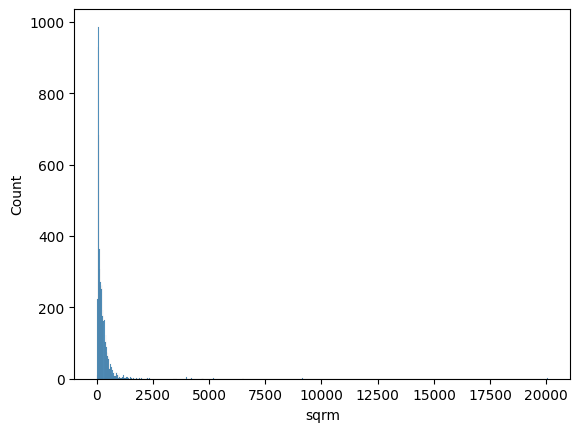

In [280]:
sns.histplot(df[df['deal_type']=='venta']['sqrm'])

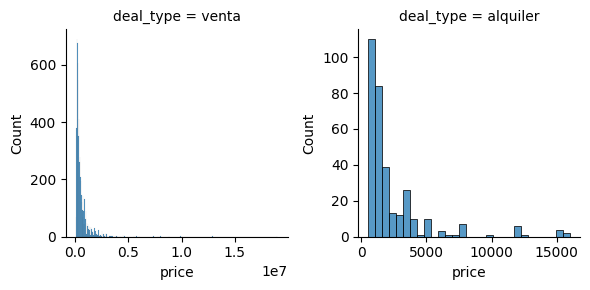

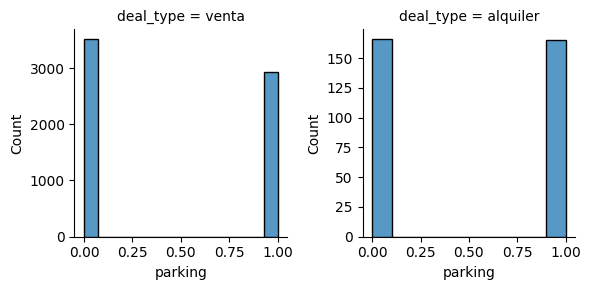

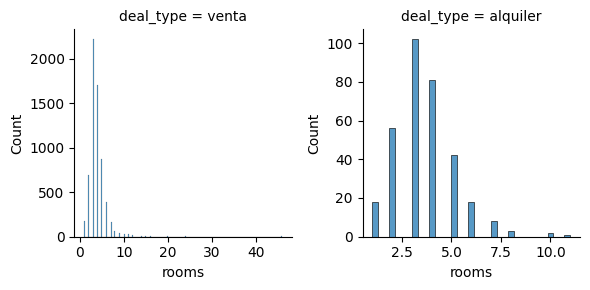

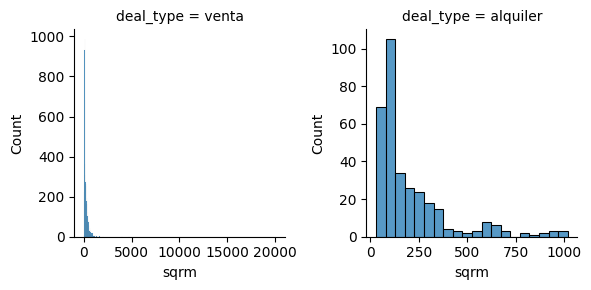

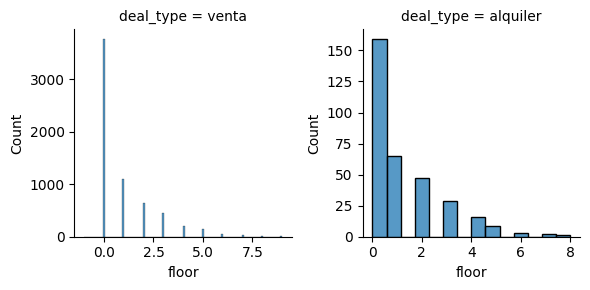

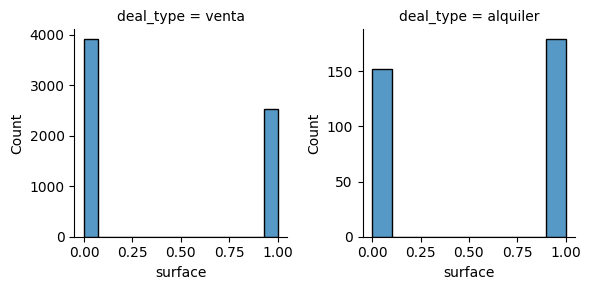

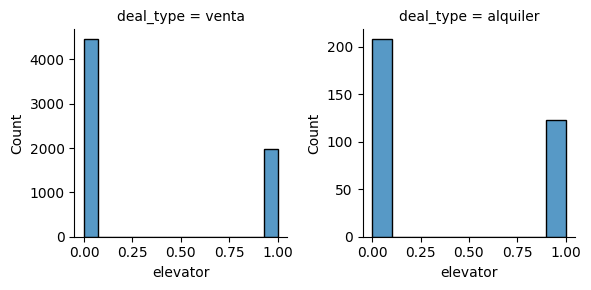

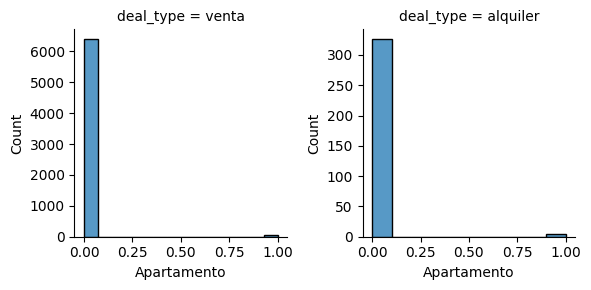

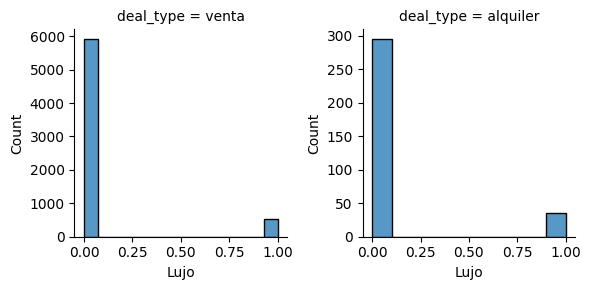

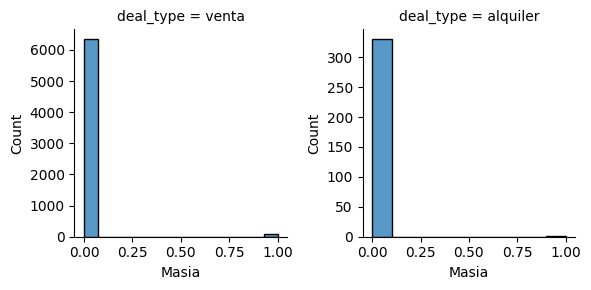

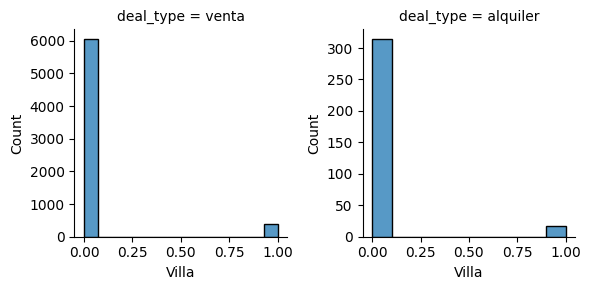

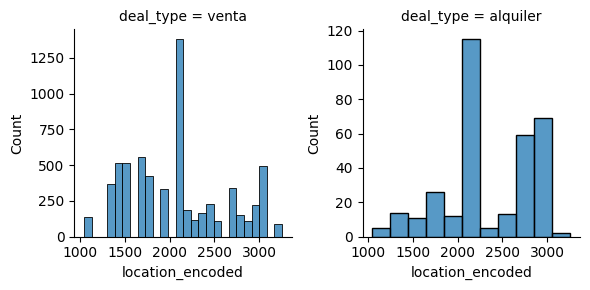

In [281]:
for i in numerical_columns:
    g = sns.FacetGrid(df, col='deal_type', sharex=False, sharey=False)
    g.map(sns.histplot, i)
    print('\n')
    plt.show()

In [282]:
df[df['deal_type']=='venta']['sqrm'].describe()

count     6435.000000
mean       241.568454
std        396.768823
min         15.000000
25%         91.000000
50%        150.000000
75%        299.500000
max      20068.000000
Name: sqrm, dtype: float64

In [283]:
df[df['deal_type']=='venta']['sqrm'].value_counts()

sqrm
80      96
90      96
100     86
110     84
85      79
        ..
352      1
736      1
386      1
1095     1
15       1
Name: count, Length: 699, dtype: int64

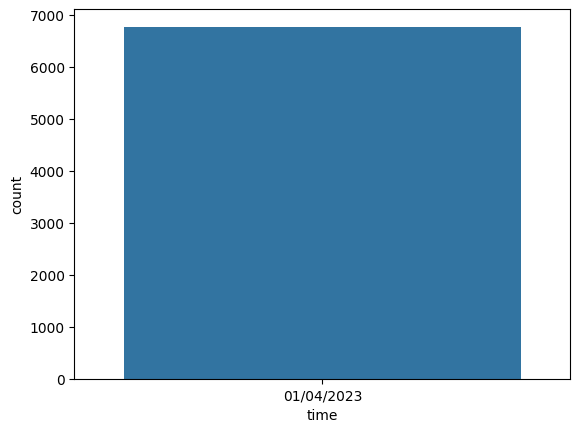

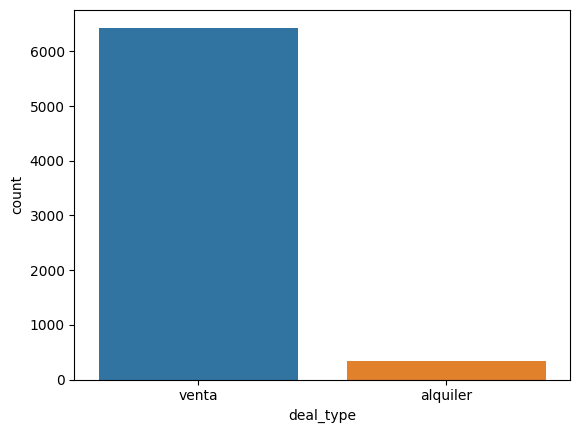

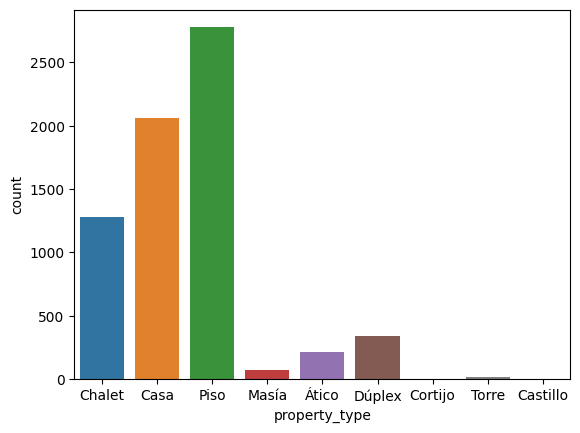

In [284]:
# Generate countplots for the categorical data
import seaborn as sns
import matplotlib.pyplot as plt
for i in categorical_columns:
    sns.countplot(data=df, x=i)
    print('\n')
    plt.show()

<Axes: >

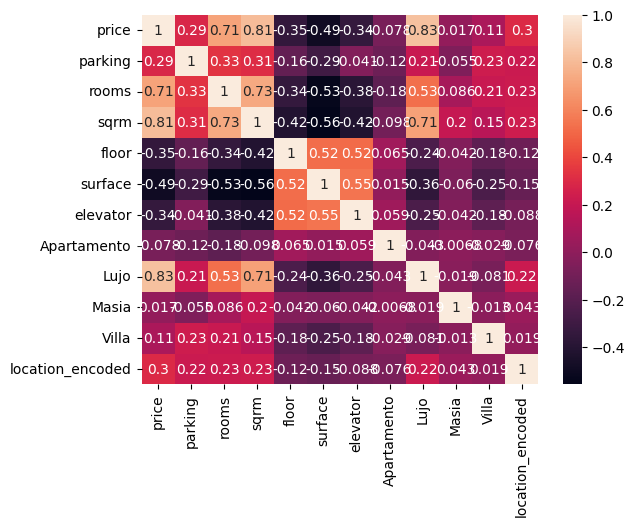

In [285]:
## Correlation
sns.heatmap(df[df['deal_type']=='alquiler'][numerical_columns].corr(), annot=True)

<Axes: >

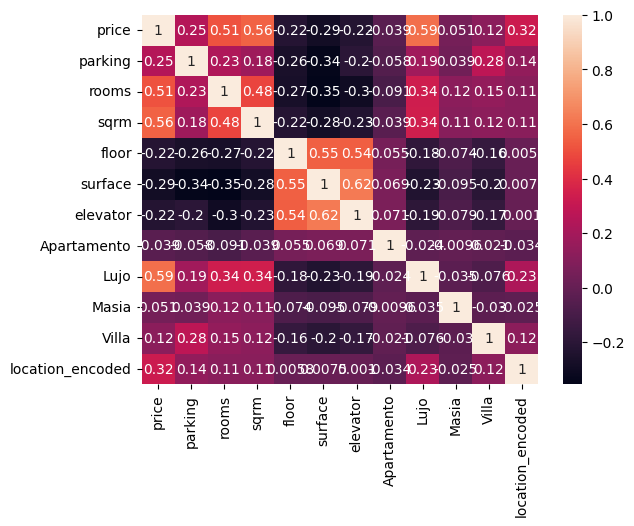

In [286]:
## Correlation
sns.heatmap(df[df['deal_type']=='venta'][numerical_columns].corr(), annot=True)

In [ ]:
# Drop any columns that have high correlation between each other

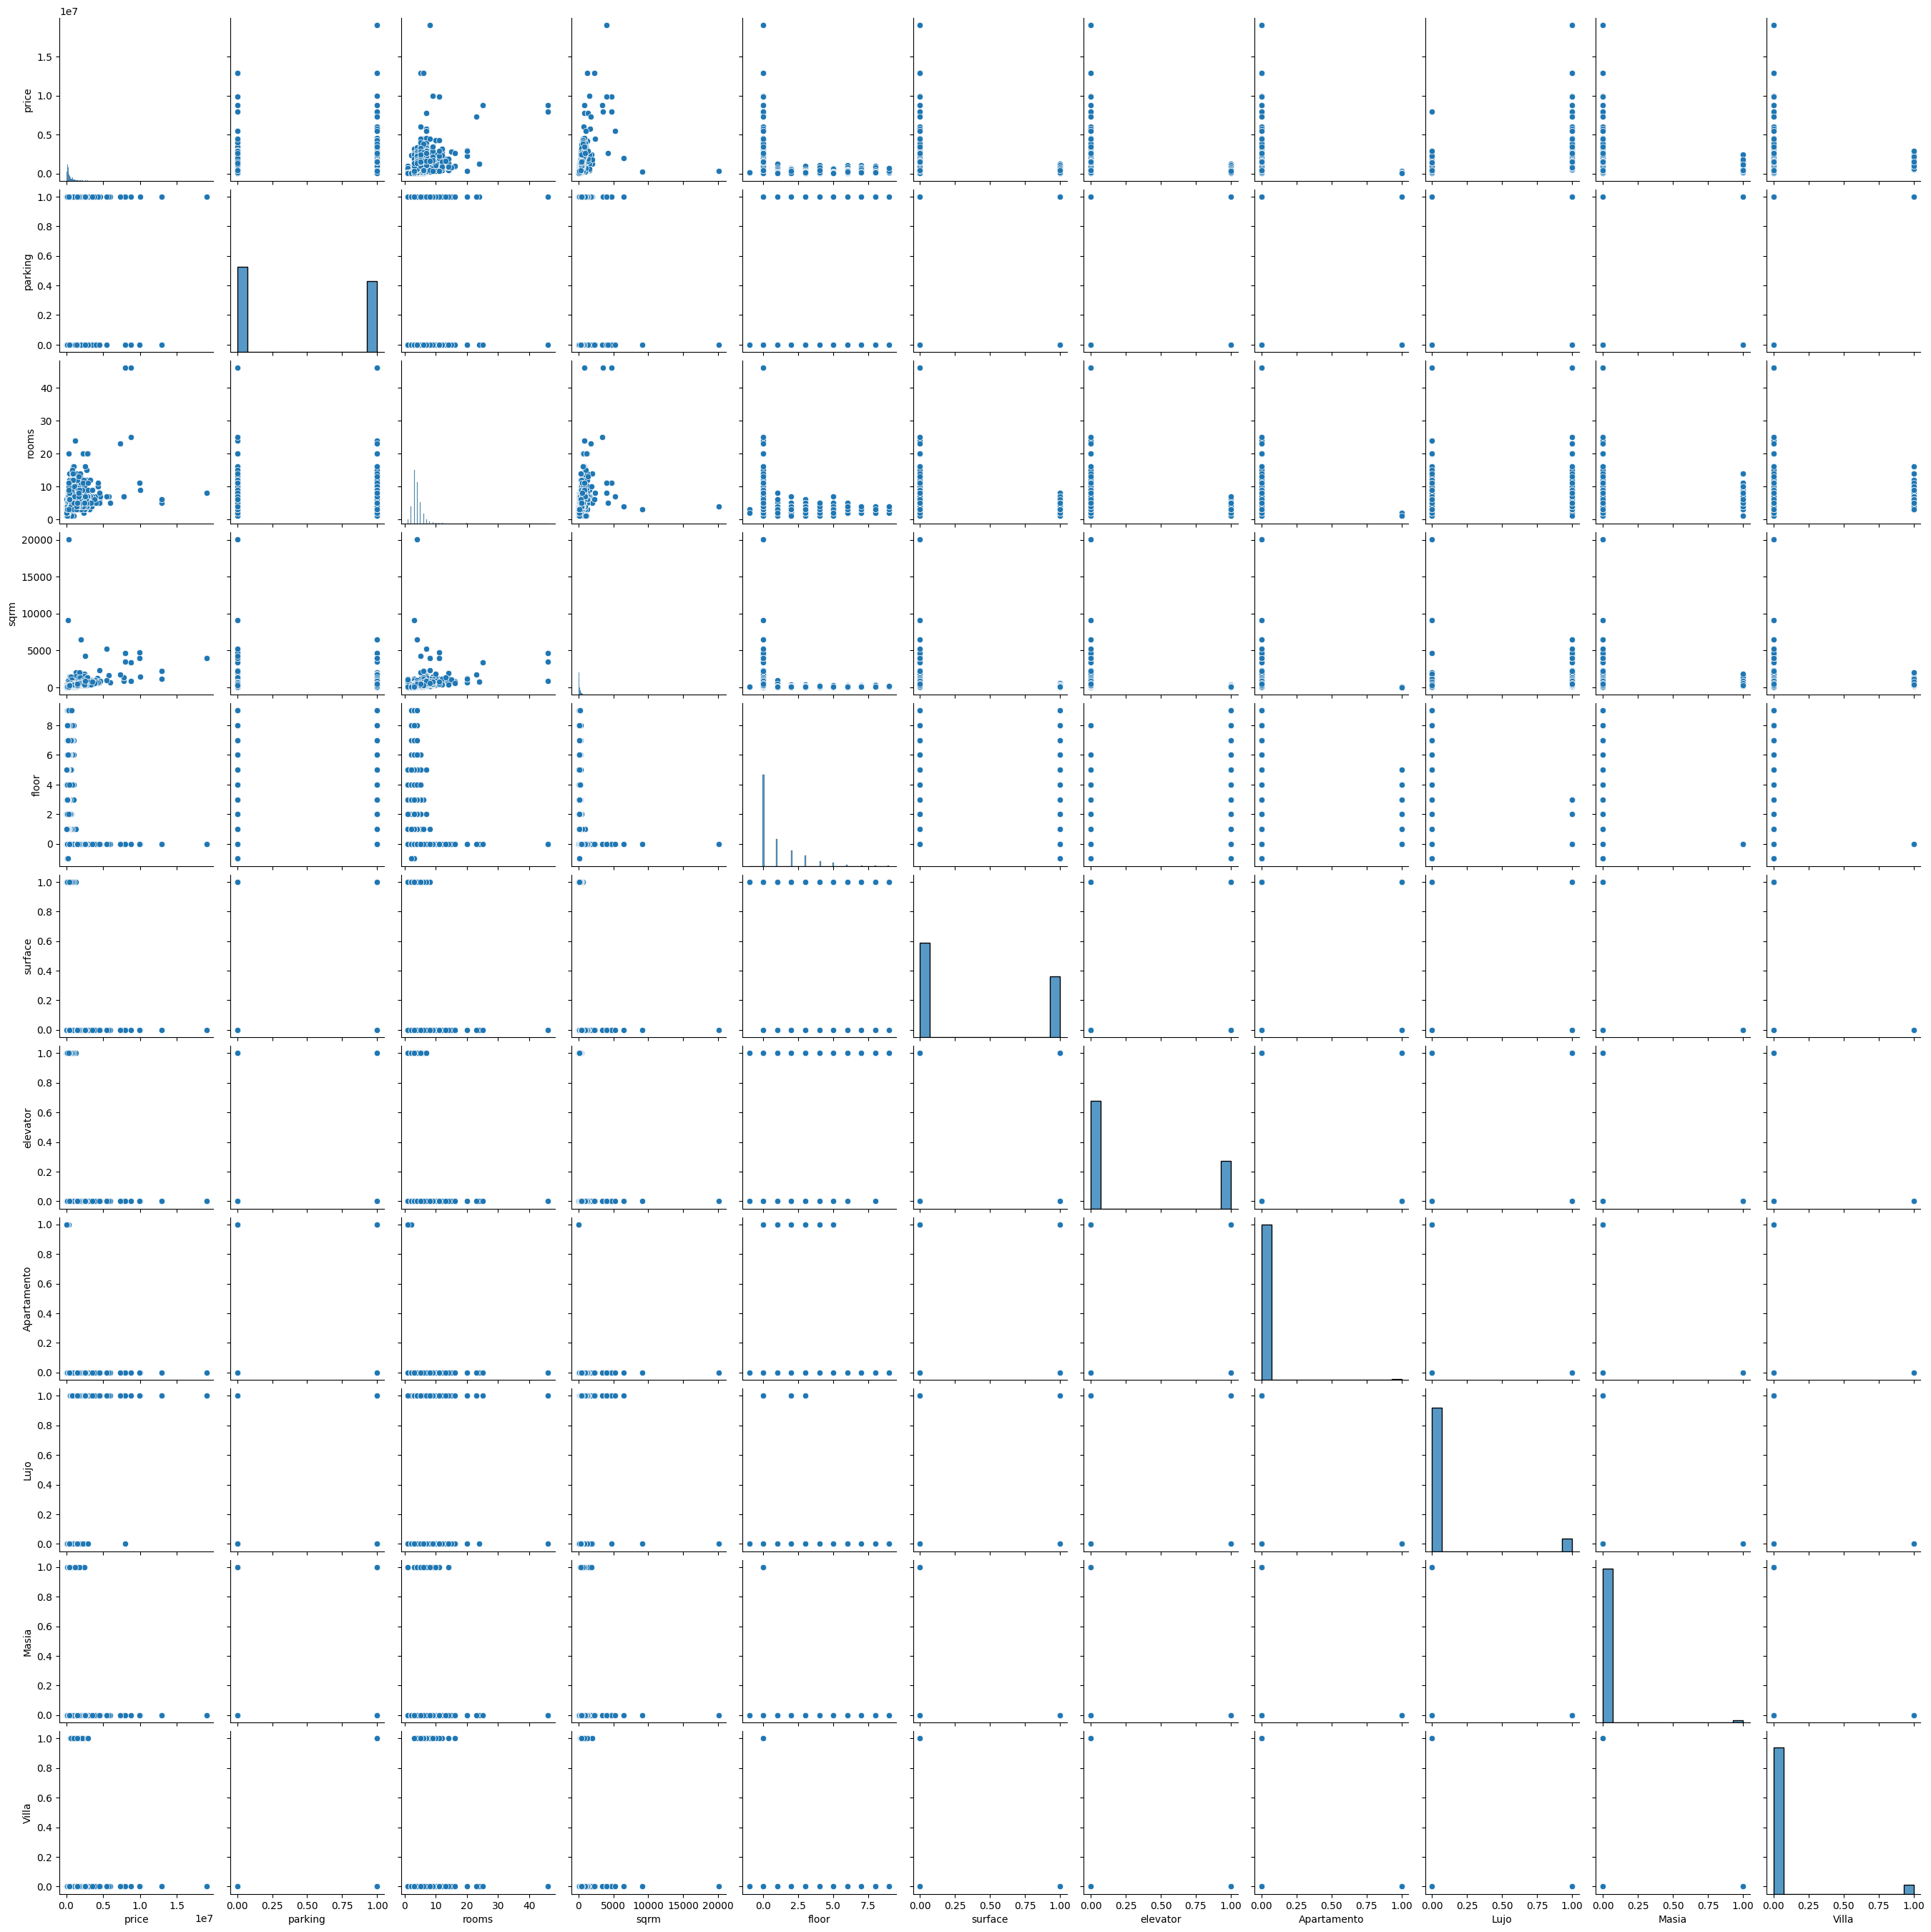

In [525]:
sns.pairplot(df[df['deal_type']=='venta'])

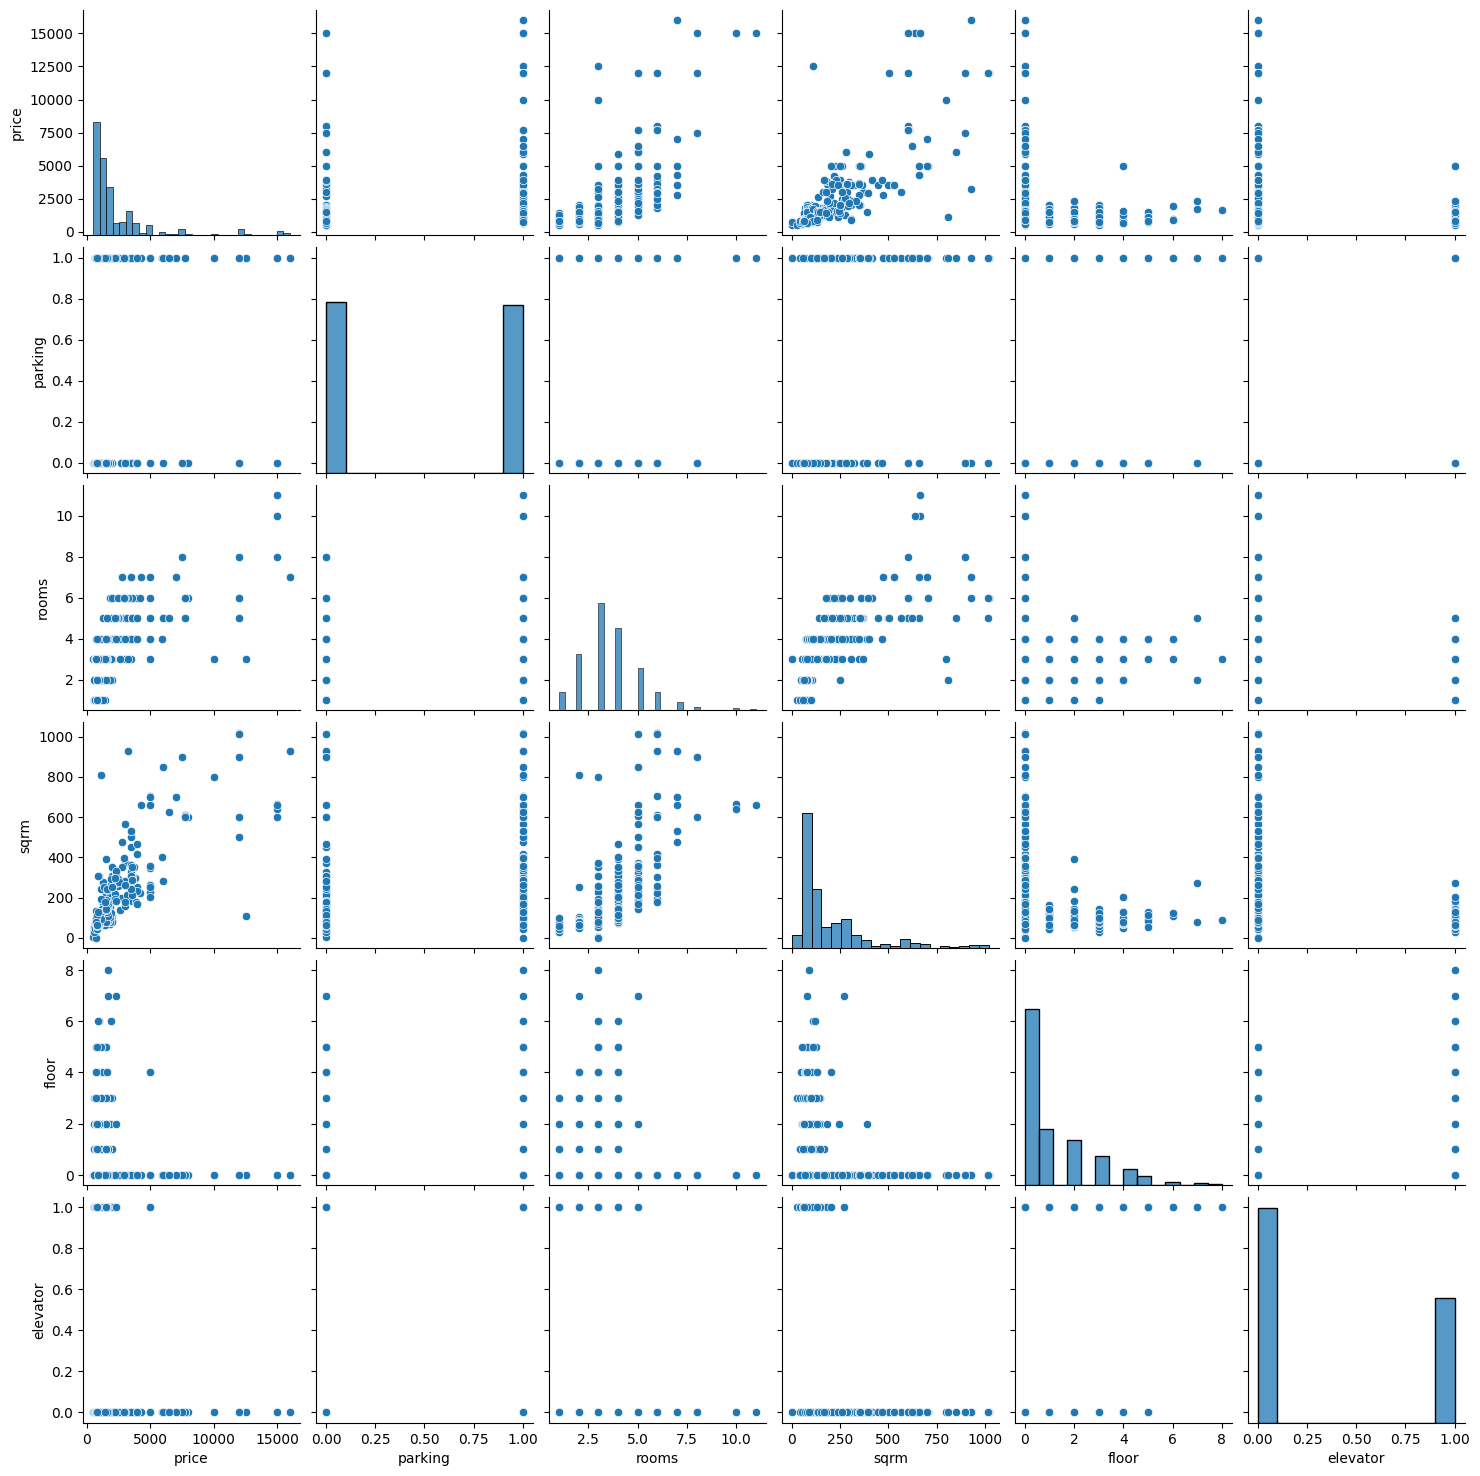

In [80]:
sns.pairplot(df[df['deal_type']=='alquiler'])

In [ ]:
# Ordinal features (with rank)